# TP547 – Princípios de Simulação de Sistemas de Comunicação
## Análise de Cadeia de Markov com Estados Absorventes

**Estudante:** Bárbara Cássia Florentino Rosa 

**Professor:** Samuel Baraldi Mafra 

**Instituição:** INATEL 

**Tema:** Analisar o comportamento de uma mosca em um sistema estocástico com dois estados absorventes usando Cadeias de Markov. Este notebook resolve passo a passo os itens propostos, utilizando visualizações, decomposição matricial e interpretação dos resultados.

---

## Conceitos Envolvidos

### Cadeias de Markov
Modelos probabilísticos com memória limitada, onde o próximo estado depende apenas do estado atual.

### Estados Absorventes
Um estado é absorvente se, uma vez atingido, o sistema permanece nele com probabilidade 1.

No nosso problema:
- Estado 0 e estado 3 são absorventes (contêm aranhas).
- Estados 1 e 2 são transitórios (mosca pode sair deles).

## 1. Importação de Bibliotecas e Definição da Matriz de Transição

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [63]:
# Definição dos estados: 0, 1, 2, 3
# P[atual][próximo]
P = np.array([
    [1.0, 0.0, 0.0, 0.0],   # estado 0 (absorvente)
    [0.3, 0.4, 0.3, 0.0],   # estado 1
    [0.0, 0.3, 0.4, 0.3],   # estado 2
    [0.0, 0.0, 0.0, 1.0]    # estado 3 (absorvente)
])

## a) O diagrama de Transição de estados.

In [64]:
def plot_transicao_markov(P):
    """
    Plota o diagrama de transição de estados de uma cadeia de Markov.

    Parâmetros:
    -----------
    P : np.ndarray (shape [n, n])
        Matriz de transição da cadeia de Markov.

    O grafo mostra:
    - Estados absorventes destacados em vermelho (estados 0 e 3).
    - Estados transitórios em verde.
    - Pesos das transições como rótulos nas arestas.
    """
    # Criação do grafo direcionado
    G = nx.DiGraph()

    states = ['0', '1', '2', '3']
    absorbing_states = ['0', '3']
    transient_states = ['1', '2']

    # Adiciona arestas com pesos baseados na matriz de transição P
    for i in range(4):
        for j in range(4):
            if P[i][j] > 0:
                G.add_edge(states[i], states[j], weight=P[i][j])

    # Layout fixo para visualização simétrica
    custom_pos = {
        '0': (-1, 0),
        '1': (-0.3, 0),
        '2': (0.3, 0),
        '3': (1, 0)
    }

    # Define cores dos nós com base no tipo de estado
    node_colors = [
        'red' if state in absorbing_states else 'lightgreen'
        for state in states
    ]

    # Rótulos das arestas (probabilidades)
    edge_labels = nx.get_edge_attributes(G, 'weight')

    # Plotagem do grafo
    plt.figure(figsize=(14, 7))
    nx.draw(
        G, custom_pos, with_labels=True,
        node_color=node_colors, node_size=2000,
        font_size=14, edge_color='gray', arrows=True
    )
    nx.draw_networkx_edge_labels(
        G, custom_pos,
        edge_labels={k: f'{v:.1f}' for k, v in edge_labels.items()},
        font_size=12
    )

    # Legenda dos tipos de estados
    absorbing_patch = mpatches.Patch(color='red', label='Estado absorvente')
    transient_patch = mpatches.Patch(color='lightgreen', label='Estado transitório')
    plt.legend(
        handles=[absorbing_patch, transient_patch],
        loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2
    )

    plt.title("Diagrama de Transição de Estados", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

C:\Users\barbararosa\AppData\Local\Temp\ipykernel_19724\276598051.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


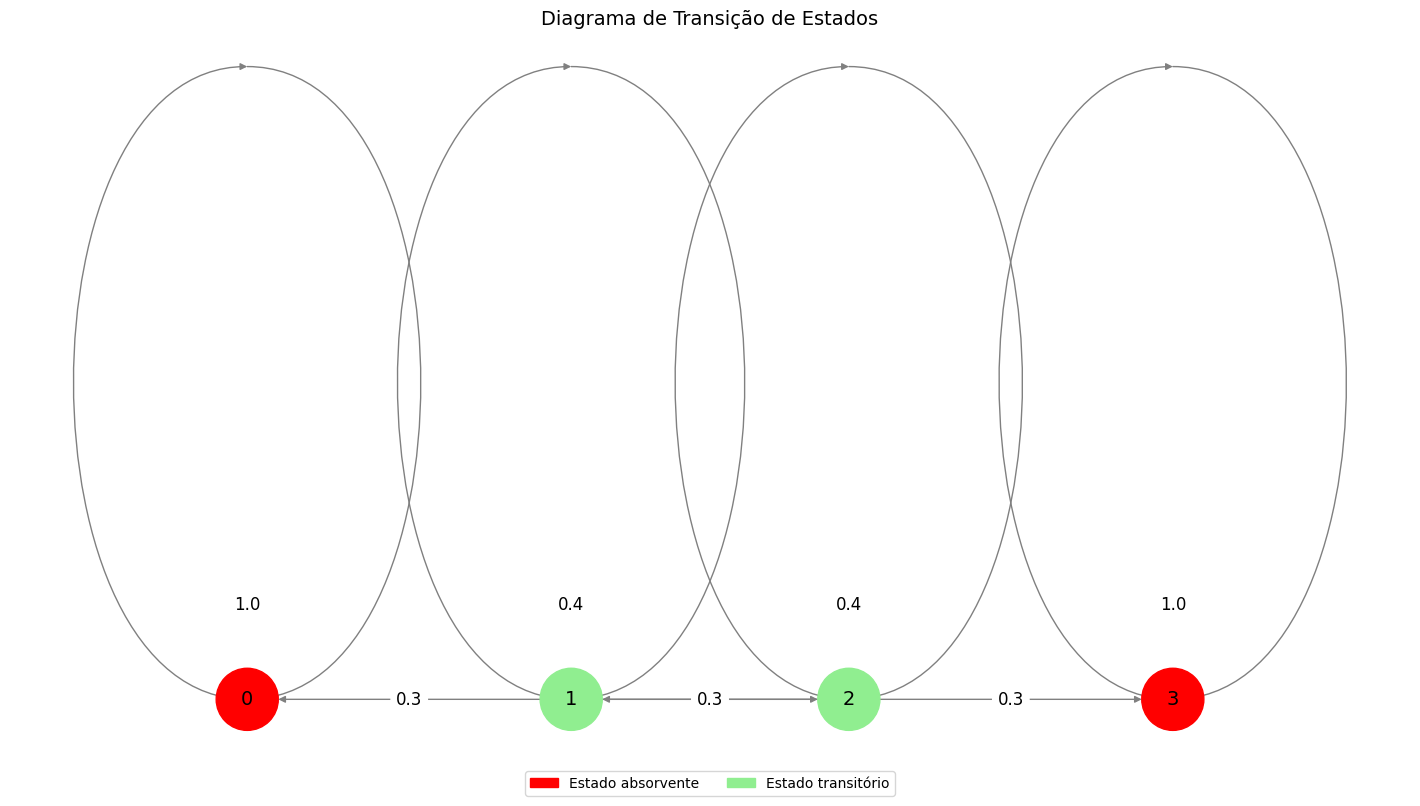

In [65]:
plot_transicao_markov(P)

> Este diagrama de transição de estados também cumpre o papel de "gráfico com transições e absorção" solicitado no item (f), pois representa visualmente a dinâmica da mosca entre compartimentos e destaca os estados absorventes onde a simulação se encerra.

## b) Matriz de Transição

#### A matriz representa as probabilidades de mover de um estado para outro a cada minuto. As linhas indicam o estado atual e as colunas, o próximo estado.

In [66]:
def exibir_matriz_transicao(P):
    """
    Exibe a matriz de transição de uma cadeia de Markov com rótulos e explicação.

    Parâmetros:
    -----------
    P : np.ndarray (shape [n, n])
        Matriz de transição da cadeia de Markov.

    A função imprime a matriz com rótulos legíveis e destaca a interpretação de P[1][0],
    que representa a transição do estado 1 para o estado 0 (estado absorvente).
    """
    estados = ['0', '1', '2', '3']
    P_df = pd.DataFrame(P, columns=estados, index=estados)

    print("Matriz de Transição de Estados (linhas = estado atual, colunas = próximo estado):")
    display(P_df)

    print("\nP[1][0] = {:.1f} → probabilidade de ir do estado 1 para o estado 0 (aranha à esquerda).".format(P[1][0]))


In [67]:
exibir_matriz_transicao(P)

Matriz de Transição de Estados (linhas = estado atual, colunas = próximo estado):


,0,1,2,3
0,1.0,0.0,0.0,0.0
1,0.3,0.4,0.3,0.0
2,0.0,0.3,0.4,0.3
3,0.0,0.0,0.0,1.0



P[1][0] = 0.3 → probabilidade de ir do estado 1 para o estado 0 (aranha à esquerda).


## c) Probabilidade de estar na teia no 3º minuto

Vamos assumir que a mosca começa no estado 1.  
Desejamos saber a probabilidade de ela estar nos **estados absorventes (0 ou 3)** após 3 passos.

A distribuição de estados após 3 minutos pode ser calculada com a multiplicação matricial:

$$
P^{(3)} = P \cdot P \cdot P
$$

Onde o vetor de estado inicial é:

$$
\mathbf{v}_0 = \begin{bmatrix} 0 & 1 & 0 & 0 \end{bmatrix}
$$

A multiplicação:
$$
\mathbf{v}_3 = \mathbf{v}_0 \cdot P^3
$$

nos dará a distribuição de probabilidade em cada estado no terceiro minuto.

In [75]:
def calcular_distribuicao_apos_3_passos(P):
    """
    Calcula e exibe a matriz de transição P³ e a distribuição de probabilidade
    após 3 passos, assumindo que a mosca começa no estado 1.

    Parâmetros:
    -----------
    P : np.ndarray (shape [4, 4])
        Matriz de transição da cadeia de Markov.

    Exibe:
    - A matriz P elevado à terceira potência.
    - A distribuição de probabilidade após 3 passos.
    - A probabilidade total de absorção (estados 0 e 3).
    """
    # Calcula P³
    P3 = np.linalg.matrix_power(P, 3)
    estados = ['0', '1', '2', '3']
    P3_df = pd.DataFrame(P3, columns=estados, index=estados)

    print("Matriz P³ (após 3 passos):")
    display(P3_df)

    # Vetor estado inicial: começa no estado 1
    v = np.array([0, 1, 0, 0])

    # Aplica a transição 3 vezes
    for _ in range(3):
        v = v @ P

    # Mostra a distribuição
    print("Distribuição de probabilidade após 3 passos (começando do estado 1):")
    for i, prob in enumerate(v):
        print(f" - Estado {i}: {prob:.4f}")

    # Probabilidade total de absorção (em estados 0 ou 3)
    absorcao = v[0] + v[3]
    print(f"\nProbabilidade total de absorção (em estados 0 ou 3) no 3º minuto: {absorcao * 100:.4f}%")

In [76]:
calcular_distribuicao_apos_3_passos(P)

Matriz P³ (após 3 passos):


,0,1,2,3
0,1.000,0.000,0.000,0.000
1,0.495,0.172,0.171,0.162
2,0.162,0.171,0.172,0.495
3,0.000,0.000,0.000,1.000


Distribuição de probabilidade após 3 passos (começando do estado 1):
 - Estado 0: 0.4950
 - Estado 1: 0.1720
 - Estado 2: 0.1710
 - Estado 3: 0.1620

Probabilidade total de absorção (em estados 0 ou 3) no 3º minuto: 65.7000%


## d) Número Médio de Passos até a Absorção

Para calcular isso, isolamos a **submatriz Q**, que contém apenas os estados transitórios (1 e 2):

$$
Q = 
\begin{bmatrix}
0.4 & 0.3 \\
0.3 & 0.4
\end{bmatrix}
$$

A matriz fundamental **N** é dada por:

$$
N = (I - Q)^{-1}
$$

A soma das linhas de $N$ nos fornece o **tempo médio até a absorção** a partir de cada estado inicial transitório.




In [70]:
def calcular_tempo_medio_ate_absorcao(P):
    """
    Calcula e exibe o tempo médio até a absorção e a matriz fundamental N
    de uma cadeia de Markov com dois estados transitórios (1 e 2)
    e dois estados absorventes (0 e 3).

    Parâmetros:
    -----------
    P : np.ndarray (shape [4, 4])
        Matriz de transição da cadeia de Markov.

    Exibe:
    - A matriz fundamental N = (I - Q)^(-1), onde Q representa os estados transitórios.
    - O tempo médio até a absorção partindo dos estados 1 e 2.
    """
    # Isola a submatriz Q com os estados transitórios (1 e 2)
    Q = P[1:3, 1:3]
    I = np.eye(Q.shape[0])
    N = np.linalg.inv(I - Q)

    # Cálculo do tempo médio até a absorção
    tempo_medio = N @ np.ones((2, 1))

    print("Tempo médio até absorção por estado inicial:")
    for i, t in enumerate(tempo_medio.flatten(), start=1):
        print(f" - Estado {i}: {t:.4f} passos")

    print("\nMatriz Fundamental N:")
    print(N)

In [71]:
calcular_tempo_medio_ate_absorcao(P)

Tempo médio até absorção por estado inicial:
 - Estado 1: 3.3333 passos
 - Estado 2: 3.3333 passos

Matriz Fundamental N:
[[2.22222222 1.11111111]
 [1.11111111 2.22222222]]


## e) Probabilidade Final de Ser Absorvido

A matriz **B** fornece a **probabilidade de absorção** de cada estado transitório para os estados absorventes:

$$
B = N \cdot R
$$

- Cada linha representa o estado inicial (1 ou 2)
- Cada coluna representa a absorção em 0 ou 3


In [77]:
def calcular_probabilidade_absorcao(P, N):
    """
    Calcula e exibe a matriz de absorção B de uma cadeia de Markov,
    mostrando a probabilidade de ser absorvido nos estados 0 e 3
    ao iniciar nos estados transitórios 1 ou 2.

    Parâmetros:
    -----------
    P : np.ndarray (shape [4, 4])
        Matriz de transição da cadeia de Markov.

    N : np.ndarray (shape [2, 2])
        Matriz fundamental calculada a partir da submatriz Q dos estados transitórios.

    Exibe:
    - A submatriz R com transições dos estados transitórios para os absorventes.
    - A matriz B = N @ R, com as probabilidades finais de absorção.
    """
    # Submatriz R: transições dos estados transitórios (1 e 2) para absorventes (0 e 3)
    R = P[1:3, [0, 3]]

    # Matriz de absorção: B = N × R
    B = N @ R

    print("Probabilidade de ser absorvido a partir de cada estado transitório:\n")
    for i in range(2):
        print(f"Iniciando no estado {i + 1}:")
        print(f" - Prob. de absorção no estado 0 (aranha à esquerda): {B[i][0] * 100:.4f}%")
        print(f" - Prob. de absorção no estado 3 (aranha à direita): {B[i][1] * 100:.4f}%\n")

In [80]:
calcular_probabilidade_absorcao(P, N)

Probabilidade de ser absorvido a partir de cada estado transitório:

Iniciando no estado 1:
 - Prob. de absorção no estado 0 (aranha à esquerda): 66.6667%
 - Prob. de absorção no estado 3 (aranha à direita): 33.3333%

Iniciando no estado 2:
 - Prob. de absorção no estado 0 (aranha à esquerda): 33.3333%
 - Prob. de absorção no estado 3 (aranha à direita): 66.6667%

